From [How to Code a Neural Network with Backpropagation In Python (from scratch)](https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/)

In [1]:
import random
import pickle
from math import exp, sqrt

import numpy as np
import matplotlib.pyplot as plt

# Rede

In [2]:
# calculate neuron activation for an input
# sum(weight_i * input_i) + bias
def activate(weights, inputs):
   activation = weights[-1]
   for i in range(len(weights)-1):
      activation += weights[i] * inputs[i]
   return activation

In [3]:
# transfer neuron activation
# sigmoid
def transfer(activation):
   return 1.0 / (1.0 + exp(-activation))

In [4]:
# forward propagate input to a network output
# each output from one layer become input to neurons in the next layer
def forward_propagate(network, row):
   inputs = row
   for layer in network:
      new_inputs = []
      for neuron in layer:
         activation = activate(neuron['weights'], inputs)
         neuron['output'] = transfer(activation)
         new_inputs.append(neuron['output'])
      inputs = new_inputs
   return inputs

In [5]:
# make a prediction with a network
def predict(network, row):
   return forward_propagate(network, row)

# Train

In [6]:
with open("data/x_treinamento.txt") as file:
    X_raw = [float(line.strip()) for line in file]

with open("data/y_treinamento.txt") as file:
    Y_raw = [float(line.strip()) for line in file]

with open("data/x_teste.txt") as file:
    X_test_raw = [float(line.strip()) for line in file]

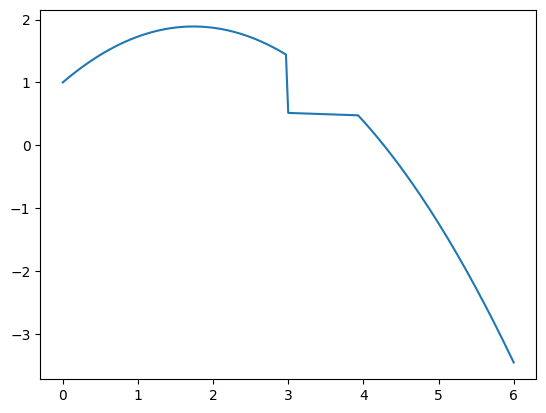

In [7]:
plt.plot(X_raw, Y_raw)

In [8]:
# normalization
mu = np.mean(X_raw)
sigma = np.std(X_raw)
X = [(x - mu)/sigma for x in X_raw]
X_test = [(x - mu)/sigma for x in X_test_raw]

m = min(Y_raw)
M = max(Y_raw)
Y = [(y - m)/(M - m) for y in Y_raw]

# PSO and DE

In [9]:
!pip install pymoo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem


n_inputs = 1
n_hidden = 10
n_outputs = 1
n_var = (n_inputs + 1)*n_hidden + (n_hidden + 1)*n_outputs

dataset = [[x, y] for x,y in zip(X, Y)]


def fill_network(x):
    x_it = iter(x)
    network = list()
    hidden_layer = [{'weights':[next(x_it) for j in range(n_inputs + 1)]} for i in range(n_hidden)]
    network.append(hidden_layer)
    output_layer = [{'weights':[next(x_it) for j in range(n_hidden + 1)]} for i in range(n_outputs)]
    network.append(output_layer)
    return network

class problem(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=n_var, n_obj=1, n_constr=0, xl=[-100 for _ in range(n_var)], xu=[100 for _ in range(n_var)])

    def _evaluate(self, x, out, *args, **kwargs):
        network = fill_network(x)
        sum_error = 0
        for row in dataset:
            outputs = forward_propagate(network, row)
            expected = [row[len(row)-i-1] for i in reversed(range(n_outputs))]
            sum_error += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
        out["F"] = [sqrt(sum_error / len(dataset))]

In [11]:
%%time

from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.pso import PSO

p = problem()
algorithm = PSO(pop_size=50, w=0.9, c1=2.0, c2=2.0)

r_pso = minimize(p, algorithm, seed=1, verbose=False, save_history=True)
print(r_pso.F, len(r_pso.history))

[0.0387343] 455
CPU times: user 1min 10s, sys: 426 ms, total: 1min 10s
Wall time: 1min 17s


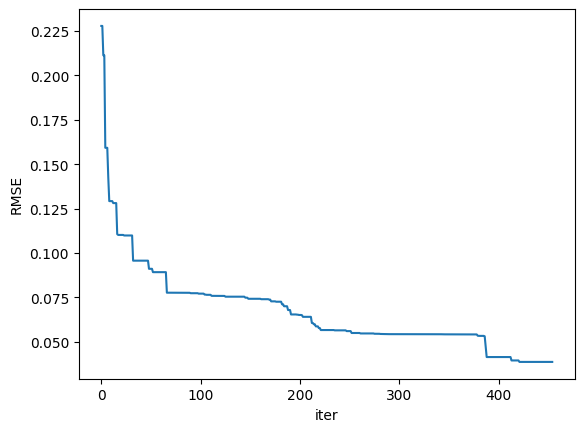

In [12]:
hist_F = []
for algo in r_pso.history:
    opt = algo.opt
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas][0][0])

plt.plot(range(len(hist_F)), hist_F)
plt.xlabel("iter")
plt.ylabel("RMSE")
plt.show()

In [13]:
file = open('data/pso_network.dat', 'wb')
network = fill_network(r_pso.X)
pickle.dump(network, file)
file.close()

In [14]:
%%time

from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.de import DE

p = problem()
algorithm = DE(pop_size=50)

r_de = minimize(p, algorithm, seed=1, verbose=False, save_history=True)
print(r_de.F, len(r_de.history))

[0.11183261] 108
CPU times: user 18.5 s, sys: 90.7 ms, total: 18.5 s
Wall time: 26.8 s


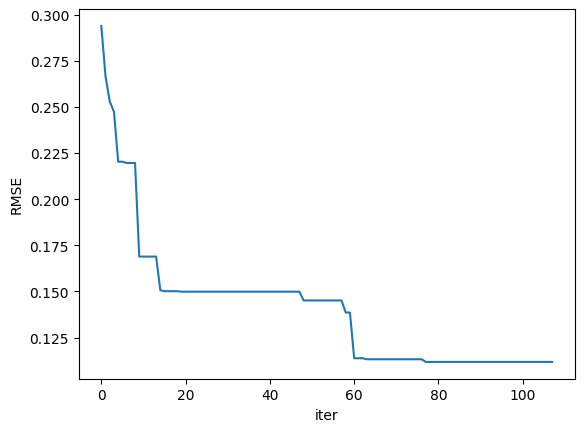

In [22]:
hist_F = []
for algo in r_de.history:
    opt = algo.opt
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas][0][0])

plt.plot(range(len(hist_F)), hist_F)
plt.xlabel("iter")
plt.ylabel("RMSE")
plt.show()

In [16]:
file = open('data/de_network.dat', 'wb')
network = fill_network(r_de.X)
pickle.dump(network, file)
file.close()

# Baseline

In [17]:
def initialize_network(n_inputs, n_hidden, n_outputs):
   network = list()
   hidden_layer = [{'weights':[random.random() for i in range(n_inputs + 1)]} for i in range(n_hidden)] # last value is bias
   network.append(hidden_layer)
   output_layer = [{'weights':[random.random() for i in range(n_hidden + 1)]} for i in range(n_outputs)] # last value is bias
   network.append(output_layer)
   return network


# calculate the derivative of an neuron output
# derivate of sigmoid
def transfer_derivative(output):
   return output * (1.0 - output)


# backpropagate error and store in neurons
def backward_propagate_error(network, expected):
   for i in reversed(range(len(network))):
      layer = network[i]
      errors = list()
      if i != len(network)-1:
         for j in range(len(layer)):
            error = 0.0
            for neuron in network[i + 1]:
               error += (neuron['weights'][j] * neuron['delta'])
            errors.append(error)
      else:
         for j in range(len(layer)):
            neuron = layer[j]
            errors.append(expected[j] - neuron['output'])
      for j in range(len(layer)):
         neuron = layer[j]
         neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])


# update network weights with error
def update_weights(network, row, l_rate):
   for i in range(len(network)):
      inputs = row[:-1]
      if i != 0:
         inputs = [neuron['output'] for neuron in network[i - 1]]
      for neuron in network[i]:
         for j in range(len(inputs)):
            neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
         neuron['weights'][-1] += l_rate * neuron['delta']


# train a network for a fixed number of epochs
def train_network(network, train, l_rate, n_epoch, n_outputs):
    for epoch in range(n_epoch):
        sum_error = 0
        for row in train:
            outputs = forward_propagate(network, row)
            expected = [row[len(row)-i-1] for i in reversed(range(n_outputs))]
            sum_error += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
            backward_propagate_error(network, expected)
            update_weights(network, row, l_rate)
        # print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))
    return sum_error

In [18]:
%%time

random.seed(1)
network = initialize_network(1, 10, 1)

r = train_network(network, dataset, 0.5, 1000, 1)
print(r)

0.2855926926958629
CPU times: user 4.62 s, sys: 15.1 ms, total: 4.64 s
Wall time: 4.65 s


In [19]:
file = open('data/bp_network.dat', 'wb')
pickle.dump(network, file)
file.close()

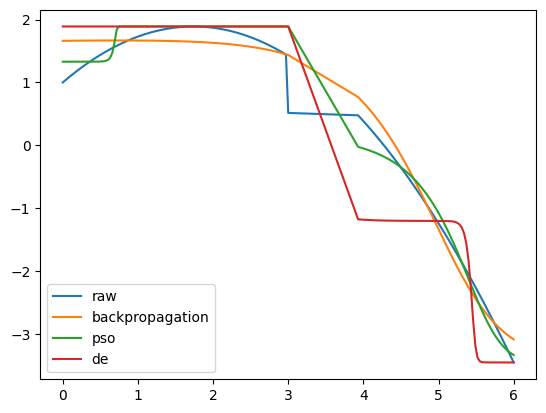

In [20]:
network_pso = fill_network(r_pso.X)
network_de = fill_network(r_de.X)
network_bp = network

prediction_pso = []
prediction_de = []
prediction_bp = []

for row in dataset:
   prediction_pso.append(predict(network_pso, row))
   prediction_de.append(predict(network_de, row))
   prediction_bp.append(predict(network_bp, row))

prediction_pso = [y[0]*(M - m) + m for y in prediction_pso]
prediction_de = [y[0]*(M - m) + m for y in prediction_de]
prediction_bp = [y[0]*(M - m) + m for y in prediction_bp]

plt.plot(X_raw, Y_raw, label="raw")
plt.plot(X_raw, prediction_bp, label="backpropagation")
plt.plot(X_raw, prediction_pso, label="pso")
plt.plot(X_raw, prediction_de, label="de")
plt.legend()
plt.show()

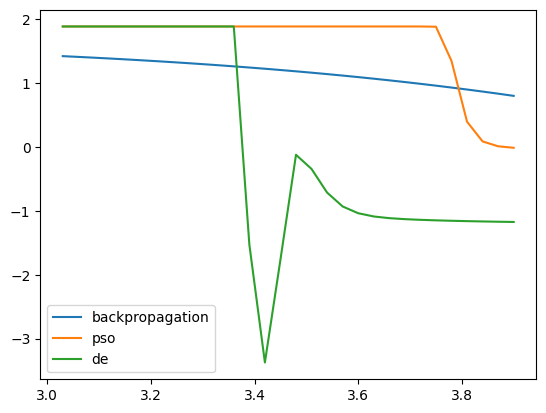

In [21]:
prediction_pso = []
prediction_de = []
prediction_bp = []

for row in [[x] for x in X_test]:
   prediction_pso.append(predict(network_pso, row))
   prediction_de.append(predict(network_de, row))
   prediction_bp.append(predict(network_bp, row))

prediction_pso = [y[0]*(M - m) + m for y in prediction_pso]
prediction_de = [y[0]*(M - m) + m for y in prediction_de]
prediction_bp = [y[0]*(M - m) + m for y in prediction_bp]

plt.plot(X_test_raw, prediction_bp, label="backpropagation")
plt.plot(X_test_raw, prediction_pso, label="pso")
plt.plot(X_test_raw, prediction_de, label="de")
plt.legend()
plt.show()